## **1. Initial Setup and Library Imports**

In [1]:
!pip install dython

In [2]:
!pip install imbalanced-learn

In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.5 MB/s eta 0:00:00


In [4]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.4 MB/s eta 0:00:00


In [47]:
# Import core libraries
import pandas as pd
import numpy as np
import math

# Import statistical libraries
from scipy.stats import pointbiserialr, chi2 as chi2_dist, mannwhitneyu, skew, ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
from dython.nominal import associations
import statsmodels.api as sm

# Import scikit-learn utilities and models
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import specific encoders and models
from category_encoders import TargetEncoder
import category_encoders as ce
from xgboost import XGBClassifier

# Import imbalanced-learn utilities
from collections import Counter
from imblearn.over_sampling import ADASYN

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## **2. Data Loading**

In [6]:
# Load primary datasets
employee_survey_df = pd.read_csv('employee_survey_data.csv')
general_df = pd.read_csv('general_data.csv')
manager_survey_df = pd.read_csv('manager_survey_data.csv')
print("Employee, general, and manager survey datasets loaded successfully.")

Employee, general, and manager survey datasets loaded successfully.


In [7]:
# Load time tracking datasets
in_time_df = pd.read_csv('in_time.csv')
out_time_df = pd.read_csv('out_time.csv')
print("In-time and out-time datasets loaded successfully.")

In-time and out-time datasets loaded successfully.


In [8]:
# Rename the first column (assumed to be EmployeeID if unnamed) for time data
in_time_df.rename(columns={in_time_df.columns[0]: 'EmployeeID'}, inplace=True)
out_time_df.rename(columns={out_time_df.columns[0]: 'EmployeeID'}, inplace=True)

## **3. Data Merging**

In [9]:
# Merge the main datasets (general, employee survey, manager survey)
merged_df = general_df.merge(employee_survey_df, on='EmployeeID', how='left')\
                      .merge(manager_survey_df, on='EmployeeID', how='left')
print("Main datasets merged.")

Main datasets merged.


## **4. Feature Engineering - Attendance Data**

In [10]:
# Separate EmployeeID before time conversion, and drop it from time dataframes
employee_ids_for_attendance = in_time_df['EmployeeID']
in_time = in_time_df.drop(columns=['EmployeeID'])
out_time = out_time_df.drop(columns=['EmployeeID'])

# Convert time columns to datetime objects, coercing errors to NaT (Not a Time)
in_time = in_time.apply(pd.to_datetime, errors='coerce')
out_time = out_time.apply(pd.to_datetime, errors='coerce')

# Calculate daily work hours in hours
work_hours = (out_time - in_time).apply(lambda x: x.dt.total_seconds() / 3600)
print("Daily work hours calculated.")

# Create attendance-related features
absent_days = work_hours.isnull().sum(axis=1)
overtime_days = (work_hours > 8).sum(axis=1)

# Create a DataFrame for these new attendance features
attendance_features_df = pd.DataFrame({
    'EmployeeID': employee_ids_for_attendance,
    'AbsentDays': absent_days,
    'OvertimeDays': overtime_days
})
print("Attendance features (AbsentDays, OvertimeDays) created.")

# Merge attendance features into the main DataFrame
merged_df = merged_df.merge(attendance_features_df, on='EmployeeID', how='left')
print("Attendance features merged into the main dataset.")

# Display the first few rows of the fully merged dataset
print("\nFirst 5 rows of the merged dataset with attendance features:")
display(merged_df.head())

Daily work hours calculated.
Attendance features (AbsentDays, OvertimeDays) created.
Attendance features merged into the main dataset.

First 5 rows of the merged dataset with attendance features:


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AbsentDays,OvertimeDays
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.000,Y,11,8,0,1.000,6,1,0,0,3.000,4.000,2.000,3,3,29,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.000,Y,23,8,1,6.000,3,5,1,4,3.000,2.000,4.000,2,4,25,42
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.000,Y,15,8,3,5.000,2,5,0,3,2.000,2.000,1.000,3,3,19,0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.000,Y,11,8,3,13.000,5,8,7,5,4.000,4.000,3.000,2,3,26,0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.000,Y,12,8,2,9.000,2,6,0,4,4.000,1.000,3.000,3,3,16,115


## **5. Data Overview and Basic Preprocessing**

In [11]:
# Display general information about the merged dataset
print("Dataset Information:")
merged_df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  Num

In [12]:
# Identify categorical and numerical columns
cat_cols_initial = merged_df.select_dtypes(include=['object']).columns.tolist()
num_cols_initial = merged_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define ordinal features
ordinal_as_cat_list = ['Education', 'JobLevel', 'StockOptionLevel', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating']

# Reclassify these ordinal features from numerical to categorical list
for col in ordinal_as_cat_list:
    if col in num_cols_initial:
        num_cols_initial.remove(col)
    if col not in cat_cols_initial:
        cat_cols_initial.append(col)

# Final lists of categorical and numerical columns
cat_cols = [c for c in cat_cols_initial if c in merged_df.columns]
num_cols = [c for c in num_cols_initial if c in merged_df.columns]

print("Categorical columns identified:")
print(cat_cols)
print("\nNumerical columns identified:")
print(num_cols)

Categorical columns identified:
['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'Education', 'JobLevel', 'StockOptionLevel', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating']

Numerical columns identified:
['Age', 'DistanceFromHome', 'EmployeeCount', 'EmployeeID', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'AbsentDays', 'OvertimeDays']


In [13]:
# Display descriptive statistics for categorical columns
print("\nDescriptive statistics for categorical columns:")
display(merged_df[cat_cols].astype('category').describe())

# Display descriptive statistics for numerical columns
print("\nDescriptive statistics for numerical columns:")
display(merged_df[num_cols].describe())


Descriptive statistics for categorical columns:


,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,Education,JobLevel,StockOptionLevel,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
count,4410,4410,4410,4410,4410,4410,4410,4410,4410,4410,4410,4385.000,4390.000,4372.000,4410,4410
unique,2,3,3,6,2,9,3,1,5,5,4,4.000,4.000,4.000,4,2
top,No,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,3,1,0,3.000,4.000,3.000,3,3
freq,3699,3129,2883,1818,2646,978,2019,4410,1716,1629,1893,1350.000,1367.000,2660.000,2604,3732



Descriptive statistics for numerical columns:


,Age,DistanceFromHome,EmployeeCount,EmployeeID,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,AbsentDays,OvertimeDays
count,4410.000,4410.000,4410.000,4410.000,4410.000,4391.000,4410.000,4410.000,4401.000,4410.000,4410.000,4410.000,4410.000,4410.000,4410.000
mean,36.924,9.193,1.000,2205.500,65029.313,2.695,15.210,8.000,11.280,2.799,7.008,2.188,4.123,24.735,76.153
std,9.133,8.105,0.000,1273.202,47068.889,2.499,3.659,0.000,7.782,1.289,6.125,3.222,3.567,5.504,100.020
min,18.000,1.000,1.000,1.000,10090.000,0.000,11.000,8.000,0.000,0.000,0.000,0.000,0.000,13.000,0.000
25%,30.000,2.000,1.000,1103.250,29110.000,1.000,12.000,8.000,6.000,2.000,3.000,0.000,2.000,20.000,0.000
50%,36.000,7.000,1.000,2205.500,49190.000,2.000,14.000,8.000,10.000,3.000,5.000,1.000,3.000,25.000,6.000
75%,43.000,14.000,1.000,3307.750,83800.000,4.000,18.000,8.000,15.000,3.000,9.000,3.000,7.000,29.000,205.000
max,60.000,29.000,1.000,4410.000,199990.000,9.000,25.000,8.000,40.000,6.000,40.000,15.000,17.000,36.000,248.000


In [14]:
# Drop unnecessary or redundant columns
# - EmployeeID is a unique identifier, not a feature for modeling.
# - EmployeeCount, Over18, and StandardHours are constant values.
cols_to_drop = ['EmployeeID', 'EmployeeCount', 'StandardHours', 'Over18']
merged_df.drop(columns=cols_to_drop, inplace=True, errors='ignore') # errors='ignore' if a col was already dropped or not present
print(f"Dropped columns: \n{cols_to_drop}")

# Update column lists after dropping
cat_cols = [col for col in cat_cols if col not in cols_to_drop]
num_cols = [col for col in num_cols if col not in cols_to_drop]

print("\nRemaining columns after dropping:")
print(merged_df.columns.tolist())

Dropped columns: 
['EmployeeID', 'EmployeeCount', 'StandardHours', 'Over18']

Remaining columns after dropping:
['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'Gender', 'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'AbsentDays', 'OvertimeDays']


## **6. Exploratory Data Analysis (EDA)**

In [15]:
# Make a copy for plots
plot_df = merged_df.copy()

In [16]:
# Prepare data for EDA: X (features) and y (target)
X_eda_original = merged_df.drop('Attrition', axis=1)
y_eda_original = merged_df['Attrition'].map({'Yes': 1, 'No': 0})

# Handle missing values for this EDA step
X_eda_imputed = X_eda_original.copy()
for col in X_eda_imputed.columns:
    if X_eda_imputed[col].dtype == 'object' or col in cat_cols:
        mode_val = X_eda_imputed[col].mode()
        X_eda_imputed[col] = X_eda_imputed[col].fillna(mode_val[0] if not mode_val.empty else 'Missing')
    else:
        X_eda_imputed[col] = X_eda_imputed[col].fillna(X_eda_imputed[col].median())

# One-hot encode categorical features for MI and Feature Importance
eda_cat_features_to_encode = [col for col in cat_cols if col in X_eda_imputed.columns]
X_eda_encoded = pd.get_dummies(X_eda_imputed, columns=eda_cat_features_to_encode, drop_first=True)

y_eda = y_eda_original.loc[X_eda_encoded.index].dropna()
X_eda_encoded = X_eda_encoded.loc[y_eda.index]

print("Data prepared for initial feature predictiveness analysis (imputed and encoded).")

Data prepared for initial feature predictiveness analysis (imputed and encoded).


In [17]:
def make_labels(bins):
   """
   Generate labels for histogram bins or data ranges.

   Args:
       bins: List of bin edges (e.g., [0, 10, 20, 30, 40])

   Returns:
       List of formatted range labels (e.g., ["0-9", "10-19", "20-29", "30+"])
   """
   return [
       f"{int(bins[i])}-{int(bins[i+1])-1}"  # Format as "start-end" for regular bins
       if i < len(bins)-2  # Check if it's not the last bin
       else f"{int(bins[i])}+"  # Format as "start+" for the final bin
       for i in range(len(bins)-1)  # Iterate through all bin pairs
   ]

In [18]:
def plot_stacked_attrition(plot_df, binning_rules, target_col='Attrition'):
   """
   Create stacked bar charts showing attrition rates across different binned variables.

   Args:
       plot_df: DataFrame containing the data to plot
       binning_rules: Dictionary where keys are column names and values are bin edges
       target_col: Target column name (default: 'Attrition')
   """

   def make_labels(bins):
       """Generate range labels for histogram bins."""
       return [
           f"{int(bins[i])}-{int(bins[i+1])-1}" if i < len(bins)-2 else f"{int(bins[i])}+"
           for i in range(len(bins)-1)
       ]

   # Set up subplot grid (2 columns, calculate rows needed)
   n_cols_plot = 2
   n_rows_plot = math.ceil(len(binning_rules) / n_cols_plot)
   fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(14, 4 * n_rows_plot))
   axes = axes.flatten()  # Convert to 1D array for easier indexing

   # Create a plot for each variable in binning_rules
   for i, (col, bins) in enumerate(binning_rules.items()):
       ax = axes[i]
       labels = make_labels(bins)

       # Create binned version of the column
       binned_col = f"{col}_bin"
       plot_df[binned_col] = pd.cut(plot_df[col], bins=bins, labels=labels, include_lowest=True)

       # Create crosstab with percentages (normalized by row)
       ctab = pd.crosstab(plot_df[binned_col], plot_df[target_col], normalize='index') * 100

       # Ensure both 'No' and 'Yes' columns exist (handle edge cases)
       if 'No' not in ctab.columns:
           ctab['No'] = 0.0
       if 'Yes' not in ctab.columns:
           ctab['Yes'] = 0.0
       ctab = ctab[['No', 'Yes']]  # Reorder columns consistently

       # Create stacked bar chart
       ctab.plot(kind='bar', stacked=True, color=['#BCBCBC', '#FF1010'],
                ax=ax, legend=False, width=0.8)

       # Add percentage labels on each bar segment
       for bar_idx, (index, row) in enumerate(ctab.iterrows()):
           bottom = 0
           for attr in ['No', 'Yes']:
               height = row[attr]
               if height > 0:  # Only add text if segment has height
                   ax.text(
                       bar_idx,           # x position (center of bar)
                       bottom + height / 2,  # y position (center of segment)
                       f"{height:.1f}%",  # percentage text
                       ha='center', va='center', fontsize=9, color='black'
                   )
                   bottom += height

       # Customize plot appearance
       ax.set_title(f'{col} vs {target_col}')
       ax.set_ylabel('%')
       ax.set_xlabel('')
       ax.set_ylim(0, 100)  # Set y-axis to 0-100%
       ax.tick_params(axis='x', rotation=0)

   # Hide unused subplots if we have more axes than variables
   for j in range(len(binning_rules), len(axes)):
       axes[j].set_visible(False)

   plt.tight_layout()
   plt.show()

In [19]:
def plot_stacked_bar_categorical(df, cat_cols, target_col='Attrition', max_categories=15, n_cols_plot=2):
   """
   Create stacked bar charts for categorical variables showing target distribution.

   Args:
       df: DataFrame containing the data
       cat_cols: List of categorical column names to plot
       target_col: Target column name (default: 'Attrition')
       max_categories: Maximum number of categories to display per variable (default: 15)
       n_cols_plot: Number of columns in the subplot grid (default: 2)
   """

   # Calculate subplot grid dimensions
   n_rows_plot = math.ceil(len(cat_cols) / n_cols_plot)
   fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(12, 5 * n_rows_plot))
   axes = axes.flatten()  # Convert to 1D array for easier indexing

   # Create a plot for each categorical variable
   for i, col_name in enumerate(cat_cols):
       ax = axes[i]

       # Get top categories by frequency to avoid overcrowded plots
       top_categories = df[col_name].value_counts().index[:max_categories]
       data = df[df[col_name].isin(top_categories)]

       # Create crosstab with percentages (normalized by row)
       dist = pd.crosstab(data[col_name], data[target_col], normalize='index') * 100

       # Ensure both 'No' and 'Yes' columns exist (handle edge cases)
       if 'No' not in dist.columns:
           dist['No'] = 0.0
       if 'Yes' not in dist.columns:
           dist['Yes'] = 0.0
       dist = dist[['No', 'Yes']]  # Reorder columns consistently
       dist = dist.sort_index()  # Sort categories alphabetically

       # Create stacked bar chart manually for better control
       bars_no = ax.bar(dist.index, dist['No'], color='#BCBCBC', label='No')
       bars_yes = ax.bar(dist.index, dist['Yes'], bottom=dist['No'], color='#FF1010', label='Yes')

       # Add percentage labels on bar segments (only if segment is large enough)
       for bar_no, bar_yes in zip(bars_no, bars_yes):
           height_no = bar_no.get_height()
           if height_no > 5:  # Only show label if segment is >5% (readable)
               ax.text(bar_no.get_x() + bar_no.get_width() / 2, height_no / 2,
                       f'{height_no:.1f}%', ha='center', va='center', fontsize=8, color='black')

           height_yes = bar_yes.get_height()
           if height_yes > 5:  # Only show label if segment is >5% (readable)
               ax.text(bar_yes.get_x() + bar_yes.get_width() / 2, height_no + height_yes / 2,
                       f'{height_yes:.1f}%', ha='center', va='center', fontsize=8, color='white')

       # Customize plot appearance
       ax.set_title(f'Distribution of {col_name} by {target_col}')
       ax.set_xlabel('')
       ax.set_ylabel('Percentage')
       ax.set_ylim(0, 100)  # Set y-axis to 0-100%
       ax.tick_params(axis='x', rotation=0)

       # Add legend only to the first subplot
       if i == 0:
           ax.legend(title=target_col)

   # Remove unused subplots if we have more axes than variables
   for j in range(len(cat_cols), len(axes)):
       fig.delaxes(axes[j])

   plt.tight_layout()
   plt.show()

In [20]:
def analyze_numerical_vs_binary(df, numerical_cols, target_col='Attrition', target_mapping={'Yes': 1, 'No': 0}):
   """
   Analyze the relationship between numerical variables and a binary target variable.

   Performs two statistical tests for each numerical variable:
   1. Point-Biserial Correlation: Measures linear relationship strength
   2. Mann-Whitney U Test: Tests if distributions differ significantly between groups

   Args:
       df: DataFrame containing the data
       numerical_cols: List of numerical column names to analyze
       target_col: Binary target column name (default: 'Attrition')
       target_mapping: Dictionary mapping target values to binary codes (default: {'Yes': 1, 'No': 0})
   """

   # Create a clean copy with only relevant columns
   temp_df = df[numerical_cols + [target_col]].copy()
   temp_df.dropna(subset=numerical_cols + [target_col], inplace=True)  # Remove missing values

   # Map target variable to binary values (0/1) for correlation calculation
   y_mapped = temp_df[target_col].map(target_mapping)

   # Analyze each numerical variable
   for feature in numerical_cols:
       # Point-Biserial Correlation: measures linear relationship between continuous and binary variables
       corr, pval_corr = pointbiserialr(temp_df[feature], y_mapped)
       print(f"Point-Biserial Correlation for {feature}: {corr:.3f} (P-value: {pval_corr:.4f})")

       # Mann-Whitney U Test: non-parametric test to compare distributions between two groups
       group_1 = temp_df[temp_df[target_col] == list(target_mapping.keys())[0]][feature]  # First group (e.g., 'Yes')
       group_2 = temp_df[temp_df[target_col] == list(target_mapping.keys())[1]][feature]  # Second group (e.g., 'No')
       u_stat, pval_u = mannwhitneyu(group_1, group_2, alternative='two-sided')
       print(f"Mann–Whitney U Test for {feature}: U={u_stat:.2f}, P-value={pval_u:.4f}\n")

In [21]:
def chi_square_test_for_categorical(
   df, cat_cols, target_col='Attrition',
   target_mapping={'Yes': 1, 'No': 0}, alpha=0.05
):
   """
   Perform Chi-Square test of independence for categorical variables against a binary target.

   Tests whether there's a significant association between each categorical variable
   and the target variable using Chi-Square test.

   Args:
       df: DataFrame containing the data
       cat_cols: List of categorical column names to test
       target_col: Binary target column name (default: 'Attrition')
       target_mapping: Dictionary mapping target values to binary codes (default: {'Yes': 1, 'No': 0})
       alpha: Significance level for the test (default: 0.05)
   """

   # Create a working copy and prepare target variable
   df = df.copy()
   df['__target__'] = df[target_col].map(target_mapping)  # Map target to binary values
   df.dropna(subset=['__target__'], inplace=True)  # Remove rows with missing target
   y_chi2 = df['__target__']

   # Test each categorical variable
   for feature in cat_cols:
       # Skip if feature is the target itself or doesn't exist
       if feature == target_col or feature not in df.columns:
           continue

       # Prepare categorical feature (handle missing values)
       raw_series = df[feature].astype(str).fillna('Missing')
       nunique = raw_series.nunique()

       # Skip if feature has only one unique value (no variation)
       if nunique <= 1:
           print(f"Feature: {feature} -> hanya punya 1 kategori unik, dilewati.\n" + "-"*50)
           continue

       # Encode categorical feature to numerical values for chi-square test
       le = LabelEncoder()
       encoded_feature = le.fit_transform(raw_series)
       encoded_feature = encoded_feature.reshape(-1, 1)

       # Perform Chi-Square test
       chi2_score, p_val = chi2(encoded_feature, y_chi2)
       df_ = nunique - 1  # Degrees of freedom = number of categories - 1
       critical_val = chi2_dist.ppf(1 - alpha, df_)

       # Display results
       print(f"Feature: {feature}")
       print(f"  - Chi-Square Score   : {chi2_score[0]:.3f}")
       print(f"  - P-Value            : {p_val[0]:.4f}")
       print(f"  - Degrees of Freedom : {df_}")
       print(f"  - Critical Value (α={alpha}) : {critical_val:.3f}")
       print(f"  - Significance       : {'Significant' if chi2_score[0] > critical_val else 'Not Significant'}")
       print()

### 6.1. Weight of Evidence (WOE) and Information Value (IV) Analysis

In [22]:
# Define the function to calculate WOE and IV
def calculate_woe_iv(df, feature, target):
  df = df.copy()
  df[feature] = df[feature].replace([np.inf, -np.inf], np.nan)

  # Binning for numeric features (excluding flags/binary indicators)
  if (df[feature].dtype.kind in 'if') and ('flag' not in feature.lower()) and (df[feature].nunique() > 10):
    try:
      df['bin'] = pd.qcut(df[feature], q=[0, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, 1], duplicates='drop').astype(str)
    except ValueError:
      df['bin'] = pd.cut(df[feature], bins=5, include_lowest=True, duplicates='drop').astype(str)
  else:
    df['bin'] = df[feature].astype(str).fillna('Missing')
    freq = df['bin'].value_counts(normalize=True)
    rare = freq[freq < 0.005].index
    df['bin'] = df['bin'].replace(rare, 'Others')

  grouped = df.groupby('bin')[target].agg(['count', lambda x: (x == 0).sum(), lambda x: (x == 1).sum()]).reset_index()
  grouped.columns = ['Value', 'All', 'Good', 'Bad']
  grouped['Feature'] = feature

  total_good = grouped['Good'].sum()
  total_bad = grouped['Bad'].sum()

  epsilon = 1e-9
  grouped['Prop_Good'] = grouped['Good'] / total_good if total_good > 0 else 0
  grouped['Prop_Bad'] = grouped['Bad'] / total_bad if total_bad > 0 else 0
  grouped['Prop_All'] = grouped['All'] / grouped['All'].sum()
  grouped['Event_Rate'] = grouped['Bad'] / grouped['All']

  grouped['WoE'] = np.log((grouped['Prop_Good'] + epsilon) / (grouped['Prop_Bad'] + epsilon))
  grouped['WoE'] = grouped['WoE'].replace([np.inf, -np.inf], [np.log((1+epsilon)/epsilon), np.log(epsilon/(1+epsilon))])

  grouped['IV_Component'] = (grouped['Prop_Good'] - grouped['Prop_Bad']) * grouped['WoE']
  iv = grouped['IV_Component'].sum()

  return grouped[['Feature', 'Value', 'All', 'Good', 'Bad', 'Event_Rate', 'Prop_All', 'Prop_Good', 'Prop_Bad', 'WoE', 'IV_Component']], iv

# Prepare data for WOE/IV calculation
target_col_name = 'Attrition'
df_for_woe = merged_df.copy()

# Ensure target column 'Attrition' is binary (0/1)
df_for_woe[target_col_name] = df_for_woe[target_col_name].map({'Yes': 1, 'No': 0})

# Drop rows where the target variable is NaN after mapping, as they can't be used.
df_for_woe.dropna(subset=[target_col_name], inplace=True)
df_for_woe[target_col_name] = df_for_woe[target_col_name].astype(int) # Ensure it's integer

# List of all feature columns (excluding the target itself)
feature_cols_for_woe = [col for col in df_for_woe.columns if col != target_col_name]

woe_iv_summary_list = []

for feature in feature_cols_for_woe:
  print(f"\nProcessing feature: {feature}")
  # Ensure the feature column has more than one unique value after handling NaNs within the function
  if df_for_woe[feature].nunique(dropna=False) <= 1 and not (df_for_woe[feature].dtype in ['float64', 'int64'] and df_for_woe[feature].nunique() > 10):
    print(f"Skipping feature '{feature}' due to having only one unique value (or NaN only).")
    woe_iv_summary_list.append({'Feature': feature, 'IV': 0.0, 'Error': 'Single unique value'})
    continue

  woe_table, iv_value = calculate_woe_iv(df_for_woe, feature, target_col_name)
  print(f"Information Value (IV) for {feature}: {iv_value:.4f}")
  display(woe_table)
  print("-" * 80)
  woe_iv_summary_list.append({'Feature': feature, 'IV': iv_value})

# Create a summary DataFrame of IV for all features
iv_summary_df = pd.DataFrame(woe_iv_summary_list).sort_values(by='IV', ascending=False)
print("\nSummary of Information Value (IV) for all features:")
display(iv_summary_df)


Processing feature: Age
Information Value (IV) for Age: 0.3286


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,Age,"(17.999, 24.0]",291,177,114,0.392,0.066,0.048,0.160,-1.209,0.136
1,Age,"(24.0, 26.0]",195,141,54,0.277,0.044,0.038,0.076,-0.689,0.026
2,Age,"(26.0, 29.0]",492,387,105,0.213,0.112,0.105,0.148,-0.345,0.015
3,Age,"(29.0, 31.0]",387,306,81,0.209,0.088,0.083,0.114,-0.320,0.010
4,Age,"(31.0, 34.0]",588,492,96,0.163,0.133,0.133,0.135,-0.015,0.000
5,Age,"(34.0, 36.0]",441,393,48,0.109,0.100,0.106,0.068,0.453,0.018
6,Age,"(36.0, 38.0]",324,300,24,0.074,0.073,0.081,0.034,0.877,0.042
7,Age,"(38.0, 41.0]",417,366,51,0.122,0.095,0.099,0.072,0.322,0.009
8,Age,"(41.0, 45.0]",456,420,36,0.079,0.103,0.114,0.051,0.808,0.051
9,Age,"(45.0, 50.0]",390,342,48,0.123,0.088,0.092,0.068,0.314,0.008


--------------------------------------------------------------------------------

Processing feature: BusinessTravel
Information Value (IV) for BusinessTravel: 0.1209


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,BusinessTravel,Non-Travel,450,414,36,0.080,0.102,0.112,0.051,0.793,0.049
1,BusinessTravel,Travel_Frequently,831,624,207,0.249,0.188,0.169,0.291,-0.546,0.067
2,BusinessTravel,Travel_Rarely,3129,2661,468,0.150,0.710,0.719,0.658,0.089,0.005


--------------------------------------------------------------------------------

Processing feature: Department
Information Value (IV) for Department: 0.0387


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,Department,Human Resources,189,132,57,0.302,0.043,0.036,0.080,-0.809,0.036
1,Department,Research & Development,2883,2430,453,0.157,0.654,0.657,0.637,0.031,0.001
2,Department,Sales,1338,1137,201,0.150,0.303,0.307,0.283,0.084,0.002


--------------------------------------------------------------------------------

Processing feature: DistanceFromHome
Information Value (IV) for DistanceFromHome: 0.0499


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,DistanceFromHome,"(0.999, 2.0]",1257,1047,210,0.167,0.285,0.283,0.295,-0.043,0.001
1,DistanceFromHome,"(11.0, 17.0]",414,333,81,0.196,0.094,0.090,0.114,-0.235,0.006
2,DistanceFromHome,"(17.0, 23.0]",411,342,69,0.168,0.093,0.092,0.097,-0.048,0.000
3,DistanceFromHome,"(2.0, 3.0]",252,222,30,0.119,0.057,0.060,0.042,0.352,0.006
4,DistanceFromHome,"(23.0, 26.0]",234,216,18,0.077,0.053,0.058,0.025,0.836,0.028
5,DistanceFromHome,"(26.0, 29.0]",186,153,33,0.177,0.042,0.041,0.046,-0.115,0.001
6,DistanceFromHome,"(3.0, 5.0]",387,324,63,0.163,0.088,0.088,0.089,-0.012,0.000
7,DistanceFromHome,"(5.0, 7.0]",429,360,69,0.161,0.097,0.097,0.097,0.003,0.000
8,DistanceFromHome,"(7.0, 9.0]",495,426,69,0.139,0.112,0.115,0.097,0.171,0.003
9,DistanceFromHome,"(9.0, 11.0]",345,276,69,0.200,0.078,0.075,0.097,-0.263,0.006


--------------------------------------------------------------------------------

Processing feature: Education
Information Value (IV) for Education: 0.0091


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,Education,1,510,432,78,0.153,0.116,0.117,0.110,0.063,0.000
1,Education,2,846,687,159,0.188,0.192,0.186,0.224,-0.186,0.007
2,Education,3,1716,1449,267,0.156,0.389,0.392,0.376,0.042,0.001
3,Education,4,1194,1008,186,0.156,0.271,0.273,0.262,0.041,0.000
4,Education,5,144,123,21,0.146,0.033,0.033,0.030,0.119,0.000


--------------------------------------------------------------------------------

Processing feature: EducationField
Information Value (IV) for EducationField: 0.0614


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,EducationField,Human Resources,81,48,33,0.407,0.018,0.013,0.046,-1.274,0.043
1,EducationField,Life Sciences,1818,1515,303,0.167,0.412,0.410,0.426,-0.040,0.001
2,EducationField,Marketing,477,402,75,0.157,0.108,0.109,0.105,0.030,0.000
3,EducationField,Medical,1392,1167,225,0.162,0.316,0.315,0.316,-0.003,0.000
4,EducationField,Other,246,216,30,0.122,0.056,0.058,0.042,0.325,0.005
5,EducationField,Technical Degree,396,351,45,0.114,0.090,0.095,0.063,0.405,0.013


--------------------------------------------------------------------------------

Processing feature: Gender
Information Value (IV) for Gender: 0.0024


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,Gender,Female,1764,1494,270,0.153,0.400,0.404,0.380,0.062,0.001
1,Gender,Male,2646,2205,441,0.167,0.600,0.596,0.620,-0.040,0.001


--------------------------------------------------------------------------------

Processing feature: JobLevel
Information Value (IV) for JobLevel: 0.0106


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,JobLevel,1,1629,1377,252,0.155,0.369,0.372,0.354,0.049,0.001
1,JobLevel,2,1602,1317,285,0.178,0.363,0.356,0.401,-0.119,0.005
2,JobLevel,3,654,558,96,0.147,0.148,0.151,0.135,0.111,0.002
3,JobLevel,4,318,267,51,0.160,0.072,0.072,0.072,0.006,0.000
4,JobLevel,5,207,180,27,0.130,0.047,0.049,0.038,0.248,0.003


--------------------------------------------------------------------------------

Processing feature: JobRole
Information Value (IV) for JobRole: 0.0420


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,JobRole,Healthcare Representative,393,336,57,0.145,0.089,0.091,0.080,0.125,0.001
1,JobRole,Human Resources,156,135,21,0.135,0.035,0.036,0.030,0.212,0.001
2,JobRole,Laboratory Technician,777,651,126,0.162,0.176,0.176,0.177,-0.007,0.000
3,JobRole,Manager,306,264,42,0.137,0.069,0.071,0.059,0.189,0.002
4,JobRole,Manufacturing Director,435,387,48,0.110,0.099,0.105,0.068,0.438,0.016
5,JobRole,Research Director,240,183,57,0.237,0.054,0.049,0.080,-0.483,0.015
6,JobRole,Research Scientist,876,717,159,0.182,0.199,0.194,0.224,-0.143,0.004
7,JobRole,Sales Executive,978,813,165,0.169,0.222,0.220,0.232,-0.054,0.001
8,JobRole,Sales Representative,249,213,36,0.145,0.056,0.058,0.051,0.129,0.001


--------------------------------------------------------------------------------

Processing feature: MaritalStatus
Information Value (IV) for MaritalStatus: 0.2189


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,MaritalStatus,Divorced,981,882,99,0.101,0.222,0.238,0.139,0.538,0.053
1,MaritalStatus,Married,2019,1767,252,0.125,0.458,0.478,0.354,0.298,0.037
2,MaritalStatus,Single,1410,1050,360,0.255,0.320,0.284,0.506,-0.579,0.129


--------------------------------------------------------------------------------

Processing feature: MonthlyIncome
Information Value (IV) for MonthlyIncome: 0.0253


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,MonthlyIncome,"(10089.999, 20970.0]",222,183,39,0.176,0.050,0.049,0.055,-0.103,0.001
1,MonthlyIncome,"(137756.0, 178560.0]",222,189,33,0.149,0.050,0.051,0.046,0.096,0.000
2,MonthlyIncome,"(178560.0, 199990.0]",219,189,30,0.137,0.050,0.051,0.042,0.191,0.002
3,MonthlyIncome,"(20970.0, 23176.0]",219,180,39,0.178,0.050,0.049,0.055,-0.120,0.001
4,MonthlyIncome,"(23176.0, 26958.0]",441,372,69,0.156,0.100,0.101,0.097,0.036,0.000
5,MonthlyIncome,"(26958.0, 33169.0]",441,363,78,0.177,0.100,0.098,0.110,-0.111,0.001
6,MonthlyIncome,"(33169.0, 42288.0]",441,375,66,0.150,0.100,0.101,0.093,0.088,0.001
7,MonthlyIncome,"(42288.0, 49190.0]",441,375,66,0.150,0.100,0.101,0.093,0.088,0.001
8,MonthlyIncome,"(49190.0, 57434.0]",441,357,84,0.190,0.100,0.097,0.118,-0.202,0.004
9,MonthlyIncome,"(57434.0, 68860.0]",441,354,87,0.197,0.100,0.096,0.122,-0.246,0.007


--------------------------------------------------------------------------------

Processing feature: NumCompaniesWorked
Information Value (IV) for NumCompaniesWorked: 0.1284


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,NumCompaniesWorked,0.0,586,517,69,0.118,0.133,0.140,0.097,0.365,0.016
1,NumCompaniesWorked,1.0,1558,1265,293,0.188,0.353,0.342,0.412,-0.186,0.013
2,NumCompaniesWorked,2.0,438,390,48,0.110,0.099,0.105,0.068,0.446,0.017
3,NumCompaniesWorked,3.0,474,426,48,0.101,0.107,0.115,0.068,0.534,0.025
4,NumCompaniesWorked,4.0,415,365,50,0.120,0.094,0.099,0.070,0.339,0.010
5,NumCompaniesWorked,5.0,187,141,46,0.246,0.042,0.038,0.065,-0.529,0.014
6,NumCompaniesWorked,6.0,208,160,48,0.231,0.047,0.043,0.068,-0.445,0.011
7,NumCompaniesWorked,7.0,222,171,51,0.230,0.050,0.046,0.072,-0.439,0.011
8,NumCompaniesWorked,8.0,147,129,18,0.122,0.033,0.035,0.025,0.320,0.003
9,NumCompaniesWorked,9.0,156,120,36,0.231,0.035,0.032,0.051,-0.445,0.008


--------------------------------------------------------------------------------

Processing feature: PercentSalaryHike
Information Value (IV) for PercentSalaryHike: 0.0168


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,PercentSalaryHike,"(10.999, 12.0]",1224,1044,180,0.147,0.278,0.282,0.253,0.109,0.003
1,PercentSalaryHike,"(12.0, 13.0]",627,525,102,0.163,0.142,0.142,0.143,-0.011,0.000
2,PercentSalaryHike,"(13.0, 14.0]",603,516,87,0.144,0.137,0.139,0.122,0.131,0.002
3,PercentSalaryHike,"(14.0, 15.0]",303,240,63,0.208,0.069,0.065,0.089,-0.312,0.007
4,PercentSalaryHike,"(15.0, 17.0]",480,405,75,0.156,0.109,0.109,0.105,0.037,0.000
5,PercentSalaryHike,"(17.0, 19.0]",495,414,81,0.164,0.112,0.112,0.114,-0.018,0.000
6,PercentSalaryHike,"(19.0, 21.0]",309,255,54,0.175,0.070,0.069,0.076,-0.097,0.001
7,PercentSalaryHike,"(21.0, 22.0]",168,138,30,0.179,0.038,0.037,0.042,-0.123,0.001
8,PercentSalaryHike,"(22.0, 25.0]",201,162,39,0.194,0.046,0.044,0.055,-0.225,0.002


--------------------------------------------------------------------------------

Processing feature: StockOptionLevel
Information Value (IV) for StockOptionLevel: 0.0051


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,StockOptionLevel,0,1893,1575,318,0.168,0.429,0.426,0.447,-0.049,0.001
1,StockOptionLevel,1,1788,1518,270,0.151,0.405,0.410,0.380,0.078,0.002
2,StockOptionLevel,2,474,390,84,0.177,0.107,0.105,0.118,-0.114,0.001
3,StockOptionLevel,3,255,216,39,0.153,0.058,0.058,0.055,0.063,0.000


--------------------------------------------------------------------------------

Processing feature: TotalWorkingYears
Information Value (IV) for TotalWorkingYears: 0.3871


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,TotalWorkingYears,"(-0.001, 1.0]",275,141,134,0.487,0.062,0.038,0.188,-1.598,0.240
1,TotalWorkingYears,"(1.0, 3.0]",219,165,54,0.247,0.050,0.045,0.076,-0.532,0.017
2,TotalWorkingYears,"(10.0, 13.0]",358,313,45,0.126,0.081,0.085,0.063,0.290,0.006
3,TotalWorkingYears,"(13.0, 17.0]",423,378,45,0.106,0.096,0.102,0.063,0.479,0.019
4,TotalWorkingYears,"(17.0, 23.0]",466,424,42,0.090,0.106,0.115,0.059,0.663,0.037
5,TotalWorkingYears,"(23.0, 28.0]",201,183,18,0.090,0.046,0.049,0.025,0.670,0.016
6,TotalWorkingYears,"(28.0, 40.0]",189,174,15,0.079,0.043,0.047,0.021,0.802,0.021
7,TotalWorkingYears,"(3.0, 5.0]",453,369,84,0.185,0.103,0.100,0.118,-0.169,0.003
8,TotalWorkingYears,"(5.0, 6.0]",375,309,66,0.176,0.085,0.084,0.093,-0.105,0.001
9,TotalWorkingYears,"(6.0, 8.0]",550,449,101,0.184,0.125,0.121,0.142,-0.157,0.003


--------------------------------------------------------------------------------

Processing feature: TrainingTimesLastYear
Information Value (IV) for TrainingTimesLastYear: 0.0494


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,TrainingTimesLastYear,0,162,132,30,0.185,0.037,0.036,0.042,-0.168,0.001
1,TrainingTimesLastYear,1,213,183,30,0.141,0.048,0.049,0.042,0.159,0.001
2,TrainingTimesLastYear,2,1641,1359,282,0.172,0.372,0.367,0.397,-0.077,0.002
3,TrainingTimesLastYear,3,1473,1215,258,0.175,0.334,0.328,0.363,-0.100,0.003
4,TrainingTimesLastYear,4,369,321,48,0.130,0.084,0.087,0.068,0.251,0.005
5,TrainingTimesLastYear,5,357,306,51,0.143,0.081,0.083,0.072,0.143,0.002
6,TrainingTimesLastYear,6,195,183,12,0.062,0.044,0.049,0.017,1.075,0.035


--------------------------------------------------------------------------------

Processing feature: YearsAtCompany
Information Value (IV) for YearsAtCompany: 0.3548


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,YearsAtCompany,"(-0.001, 1.0]",645,420,225,0.349,0.146,0.114,0.316,-1.025,0.208
1,YearsAtCompany,"(1.0, 2.0]",381,300,81,0.213,0.086,0.081,0.114,-0.340,0.011
2,YearsAtCompany,"(10.0, 15.0]",324,303,21,0.065,0.073,0.082,0.030,1.020,0.053
3,YearsAtCompany,"(15.0, 20.0]",216,201,15,0.069,0.049,0.054,0.021,0.946,0.031
4,YearsAtCompany,"(2.0, 3.0]",384,324,60,0.156,0.087,0.088,0.084,0.037,0.000
5,YearsAtCompany,"(20.0, 40.0]",198,174,24,0.121,0.045,0.047,0.034,0.332,0.004
6,YearsAtCompany,"(3.0, 5.0]",918,798,120,0.131,0.208,0.216,0.169,0.245,0.012
7,YearsAtCompany,"(5.0, 7.0]",498,438,60,0.120,0.113,0.118,0.084,0.339,0.012
8,YearsAtCompany,"(7.0, 9.0]",486,435,51,0.105,0.110,0.118,0.072,0.494,0.023
9,YearsAtCompany,"(9.0, 10.0]",360,306,54,0.150,0.082,0.083,0.076,0.085,0.001


--------------------------------------------------------------------------------

Processing feature: YearsSinceLastPromotion
Information Value (IV) for YearsSinceLastPromotion: 0.0166


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,YearsSinceLastPromotion,"(-0.001, 1.0]",2814,2337,477,0.170,0.638,0.632,0.671,-0.060,0.002
1,YearsSinceLastPromotion,"(1.0, 2.0]",477,396,81,0.170,0.108,0.107,0.114,-0.062,0.000
2,YearsSinceLastPromotion,"(2.0, 4.0]",339,297,42,0.124,0.077,0.080,0.059,0.307,0.007
3,YearsSinceLastPromotion,"(4.0, 7.0]",459,387,72,0.157,0.104,0.105,0.101,0.033,0.000
4,YearsSinceLastPromotion,"(7.0, 9.0]",105,93,12,0.114,0.024,0.025,0.017,0.399,0.003
5,YearsSinceLastPromotion,"(9.0, 15.0]",216,189,27,0.125,0.049,0.051,0.038,0.297,0.004


--------------------------------------------------------------------------------

Processing feature: YearsWithCurrManager
Information Value (IV) for YearsWithCurrManager: 0.2772


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,YearsWithCurrManager,"(-0.001, 1.0]",1017,729,288,0.283,0.231,0.197,0.405,-0.720,0.150
1,YearsWithCurrManager,"(1.0, 2.0]",1032,882,150,0.145,0.234,0.238,0.211,0.122,0.003
2,YearsWithCurrManager,"(10.0, 17.0]",219,210,9,0.041,0.050,0.057,0.013,1.501,0.066
3,YearsWithCurrManager,"(2.0, 3.0]",426,369,57,0.134,0.097,0.100,0.080,0.219,0.004
4,YearsWithCurrManager,"(3.0, 4.0]",294,261,33,0.112,0.067,0.071,0.046,0.419,0.010
5,YearsWithCurrManager,"(4.0, 7.0]",828,711,117,0.141,0.188,0.192,0.165,0.155,0.004
6,YearsWithCurrManager,"(7.0, 9.0]",513,465,48,0.094,0.116,0.126,0.068,0.622,0.036
7,YearsWithCurrManager,"(9.0, 10.0]",81,72,9,0.111,0.018,0.019,0.013,0.430,0.003


--------------------------------------------------------------------------------

Processing feature: EnvironmentSatisfaction
Information Value (IV) for EnvironmentSatisfaction: 0.0970


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,EnvironmentSatisfaction,1.0,845,632,213,0.252,0.192,0.171,0.300,-0.562,0.072
1,EnvironmentSatisfaction,2.0,856,728,128,0.150,0.194,0.197,0.180,0.089,0.001
2,EnvironmentSatisfaction,3.0,1350,1164,186,0.138,0.306,0.315,0.262,0.185,0.010
3,EnvironmentSatisfaction,4.0,1334,1155,179,0.134,0.302,0.312,0.252,0.215,0.013
4,EnvironmentSatisfaction,nan,25,20,5,0.200,0.006,0.005,0.007,-0.263,0.000


--------------------------------------------------------------------------------

Processing feature: JobSatisfaction
Information Value (IV) for JobSatisfaction: 0.0911


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,JobSatisfaction,1.0,860,663,197,0.229,0.195,0.179,0.277,-0.436,0.043
1,JobSatisfaction,2.0,840,702,138,0.164,0.190,0.190,0.194,-0.022,0.000
2,JobSatisfaction,3.0,1323,1104,219,0.166,0.300,0.298,0.308,-0.032,0.000
3,JobSatisfaction,4.0,1367,1211,156,0.114,0.310,0.327,0.219,0.400,0.043
4,JobSatisfaction,Others,20,19,1,0.050,0.005,0.005,0.001,1.295,0.005


--------------------------------------------------------------------------------

Processing feature: WorkLifeBalance
Information Value (IV) for WorkLifeBalance: 0.0686


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,WorkLifeBalance,1.0,239,164,75,0.314,0.054,0.044,0.105,-0.867,0.053
1,WorkLifeBalance,2.0,1019,848,171,0.168,0.231,0.229,0.241,-0.048,0.001
2,WorkLifeBalance,3.0,2660,2280,380,0.143,0.603,0.616,0.534,0.143,0.012
3,WorkLifeBalance,4.0,454,373,81,0.178,0.103,0.101,0.114,-0.122,0.002
4,WorkLifeBalance,nan,38,34,4,0.105,0.009,0.009,0.006,0.491,0.002


--------------------------------------------------------------------------------

Processing feature: JobInvolvement
Information Value (IV) for JobInvolvement: 0.0125


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,JobInvolvement,1,249,195,54,0.217,0.056,0.053,0.076,-0.365,0.008
1,JobInvolvement,2,1125,945,180,0.160,0.255,0.255,0.253,0.009,0.000
2,JobInvolvement,3,2604,2205,399,0.153,0.590,0.596,0.561,0.060,0.002
3,JobInvolvement,4,432,354,78,0.181,0.098,0.096,0.110,-0.137,0.002


--------------------------------------------------------------------------------

Processing feature: PerformanceRating
Information Value (IV) for PerformanceRating: 0.0039


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,PerformanceRating,3,3732,3144,588,0.158,0.846,0.850,0.827,0.027,0.001
1,PerformanceRating,4,678,555,123,0.181,0.154,0.150,0.173,-0.142,0.003


--------------------------------------------------------------------------------

Processing feature: AbsentDays
Information Value (IV) for AbsentDays: 0.0563


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,AbsentDays,"(12.999, 16.0]",261,205,56,0.215,0.059,0.055,0.079,-0.351,0.008
1,AbsentDays,"(16.0, 17.0]",204,170,34,0.167,0.046,0.046,0.048,-0.040,0.000
2,AbsentDays,"(17.0, 19.0]",514,435,79,0.154,0.117,0.118,0.111,0.057,0.000
3,AbsentDays,"(19.0, 21.0]",456,367,89,0.195,0.103,0.099,0.125,-0.232,0.006
4,AbsentDays,"(21.0, 23.0]",486,410,76,0.156,0.110,0.111,0.107,0.036,0.000
5,AbsentDays,"(23.0, 25.0]",454,393,61,0.134,0.103,0.106,0.086,0.214,0.004
6,AbsentDays,"(25.0, 27.0]",482,396,86,0.178,0.109,0.107,0.121,-0.122,0.002
7,AbsentDays,"(27.0, 29.0]",473,392,81,0.171,0.107,0.106,0.114,-0.072,0.001
8,AbsentDays,"(29.0, 30.0]",245,207,38,0.155,0.056,0.056,0.053,0.046,0.000
9,AbsentDays,"(30.0, 32.0]",464,389,75,0.162,0.105,0.105,0.105,-0.003,0.000


--------------------------------------------------------------------------------

Processing feature: OvertimeDays
Information Value (IV) for OvertimeDays: 0.3629


,Feature,Value,All,Good,Bad,Event_Rate,Prop_All,Prop_Good,Prop_Bad,WoE,IV_Component
0,OvertimeDays,"(-0.001, 6.0]",2222,2004,218,0.098,0.504,0.542,0.307,0.569,0.134
1,OvertimeDays,"(117.3, 231.0]",444,313,131,0.295,0.101,0.085,0.184,-0.778,0.078
2,OvertimeDays,"(231.0, 239.0]",461,330,131,0.284,0.105,0.089,0.184,-0.725,0.069
3,OvertimeDays,"(239.0, 243.0]",209,145,64,0.306,0.047,0.039,0.090,-0.831,0.042
4,OvertimeDays,"(243.0, 248.0]",209,152,57,0.273,0.047,0.041,0.080,-0.668,0.026
5,OvertimeDays,"(39.0, 117.3]",436,378,58,0.133,0.099,0.102,0.082,0.225,0.005
6,OvertimeDays,"(6.0, 39.0]",429,377,52,0.121,0.097,0.102,0.073,0.332,0.010


--------------------------------------------------------------------------------

Summary of Information Value (IV) for all features:


,Feature,IV
14,TotalWorkingYears,0.387
25,OvertimeDays,0.363
16,YearsAtCompany,0.355
0,Age,0.329
18,YearsWithCurrManager,0.277
9,MaritalStatus,0.219
11,NumCompaniesWorked,0.128
1,BusinessTravel,0.121
19,EnvironmentSatisfaction,0.097
20,JobSatisfaction,0.091


### 6.2. Variable Distribution Analysis (Visualizations)

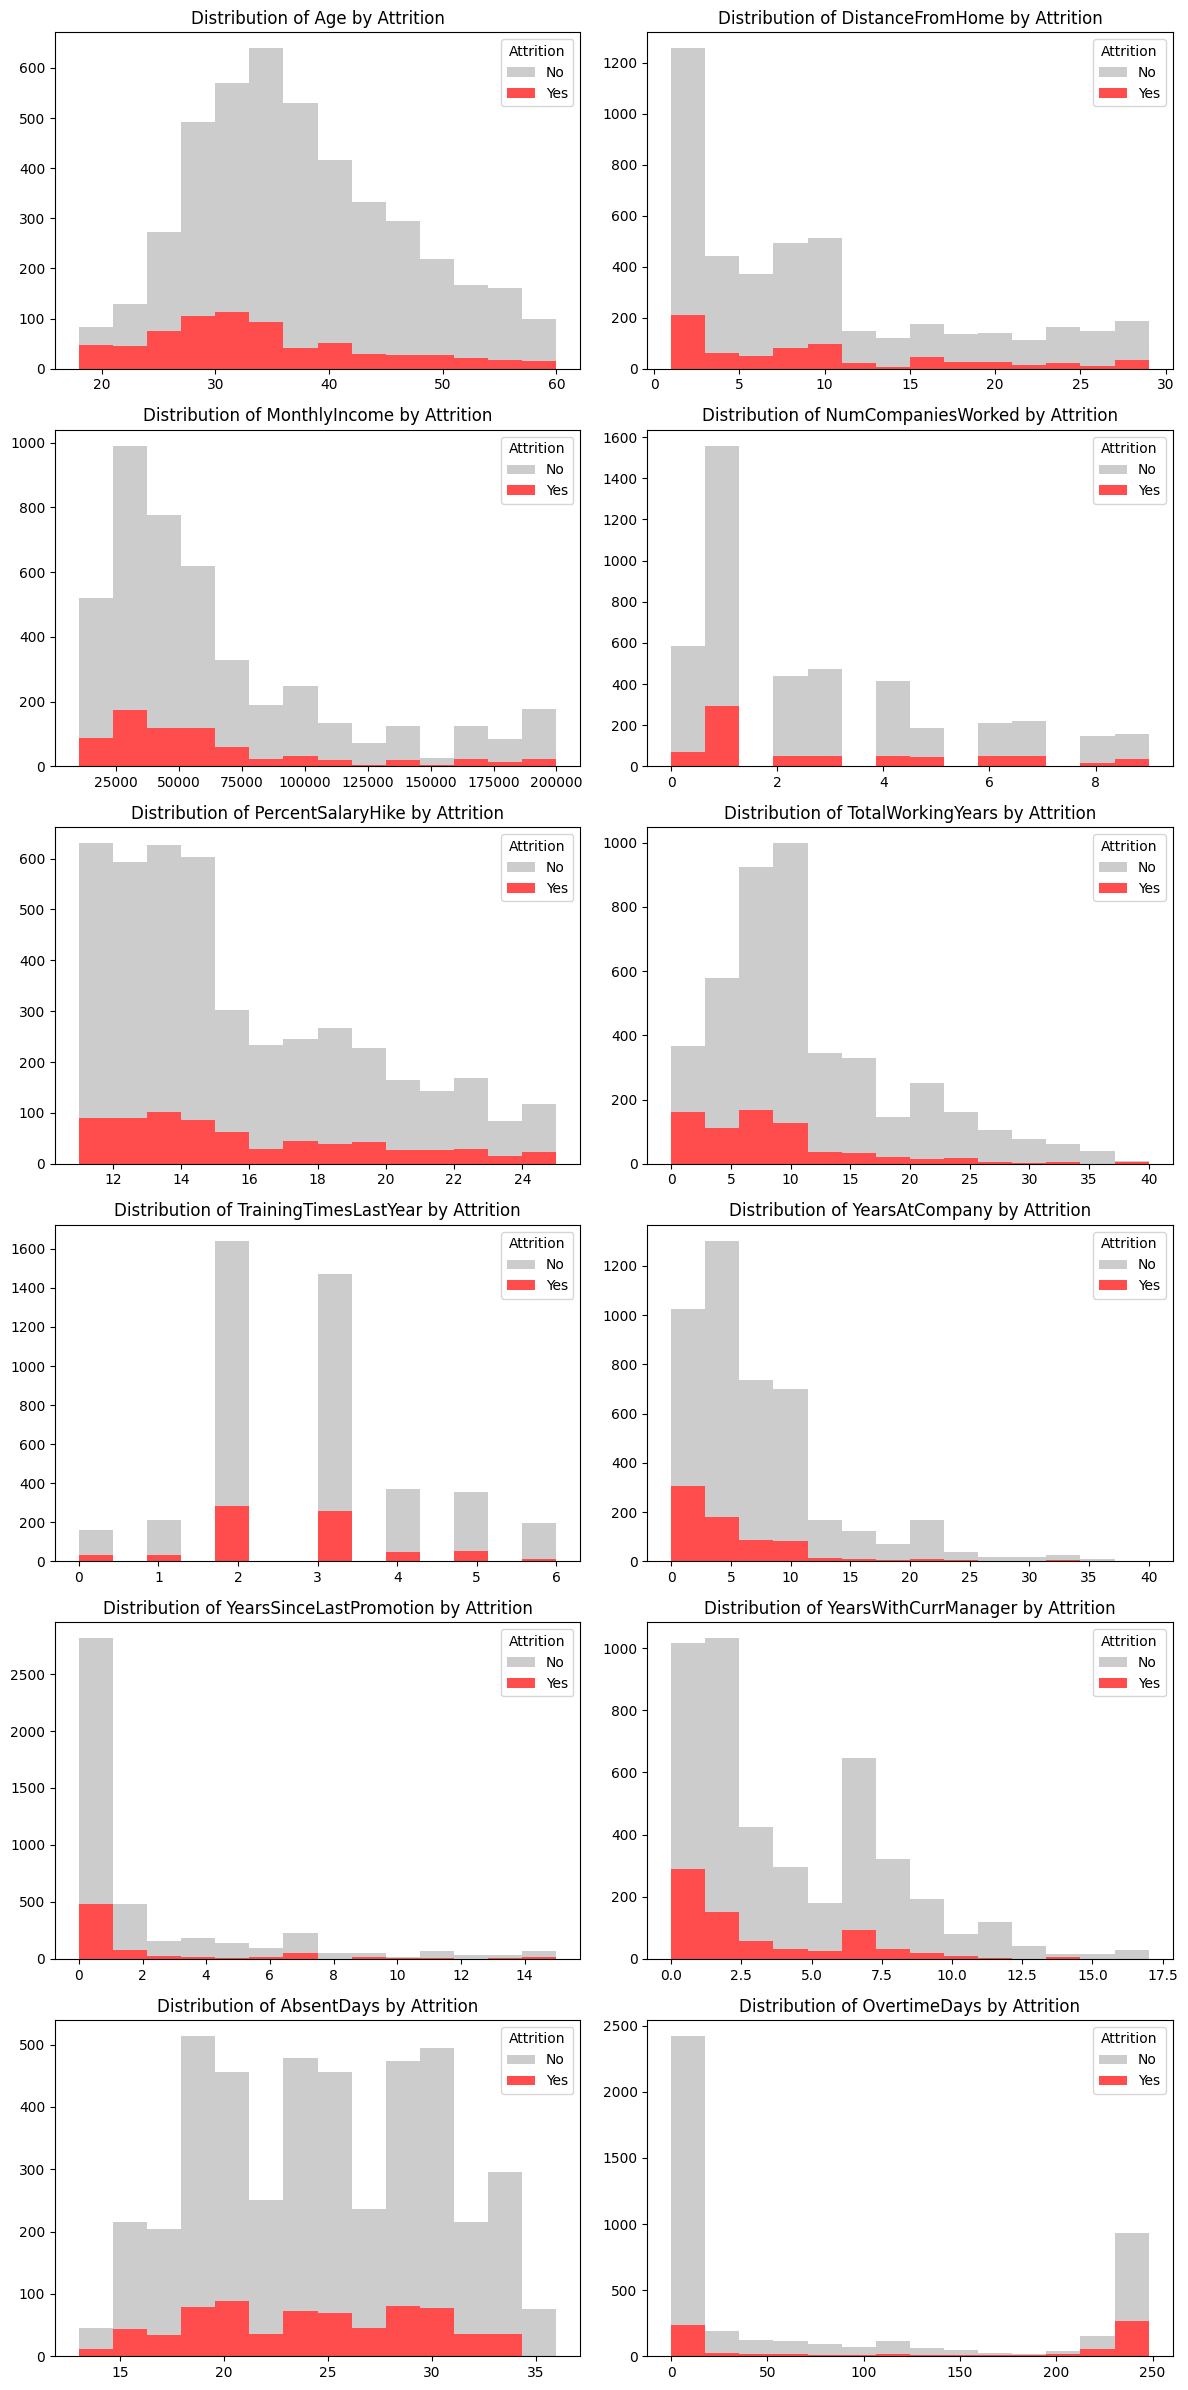

In [23]:
# Histograms for Numerical Features
n_cols_plot = 2
n_rows_plot = math.ceil(len(num_cols) / n_cols_plot)

fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(12, 4 * n_rows_plot))
axes = axes.flatten()

for i, col_name in enumerate(num_cols):
  ax = axes[i]
  # Sturges' rule for number of bins: bins ≈ log2(n) + 1
  n_non_null = plot_df[col_name].dropna().shape[0]
  bins = math.ceil(np.log2(n_non_null) + 1) if n_non_null > 0 else 10

  sns.histplot(
    data=plot_df,
    x=col_name,
    hue='Attrition',
    multiple='stack',
    bins=bins,
    edgecolor=None,
    palette={'Yes': '#FF1010', 'No': '#BCBCBC'},
    ax=ax
  )
  ax.set_title(f'Distribution of {col_name} by Attrition')
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.tick_params(axis='x')

  # Hide any unused subplots
  for j in range(len(num_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

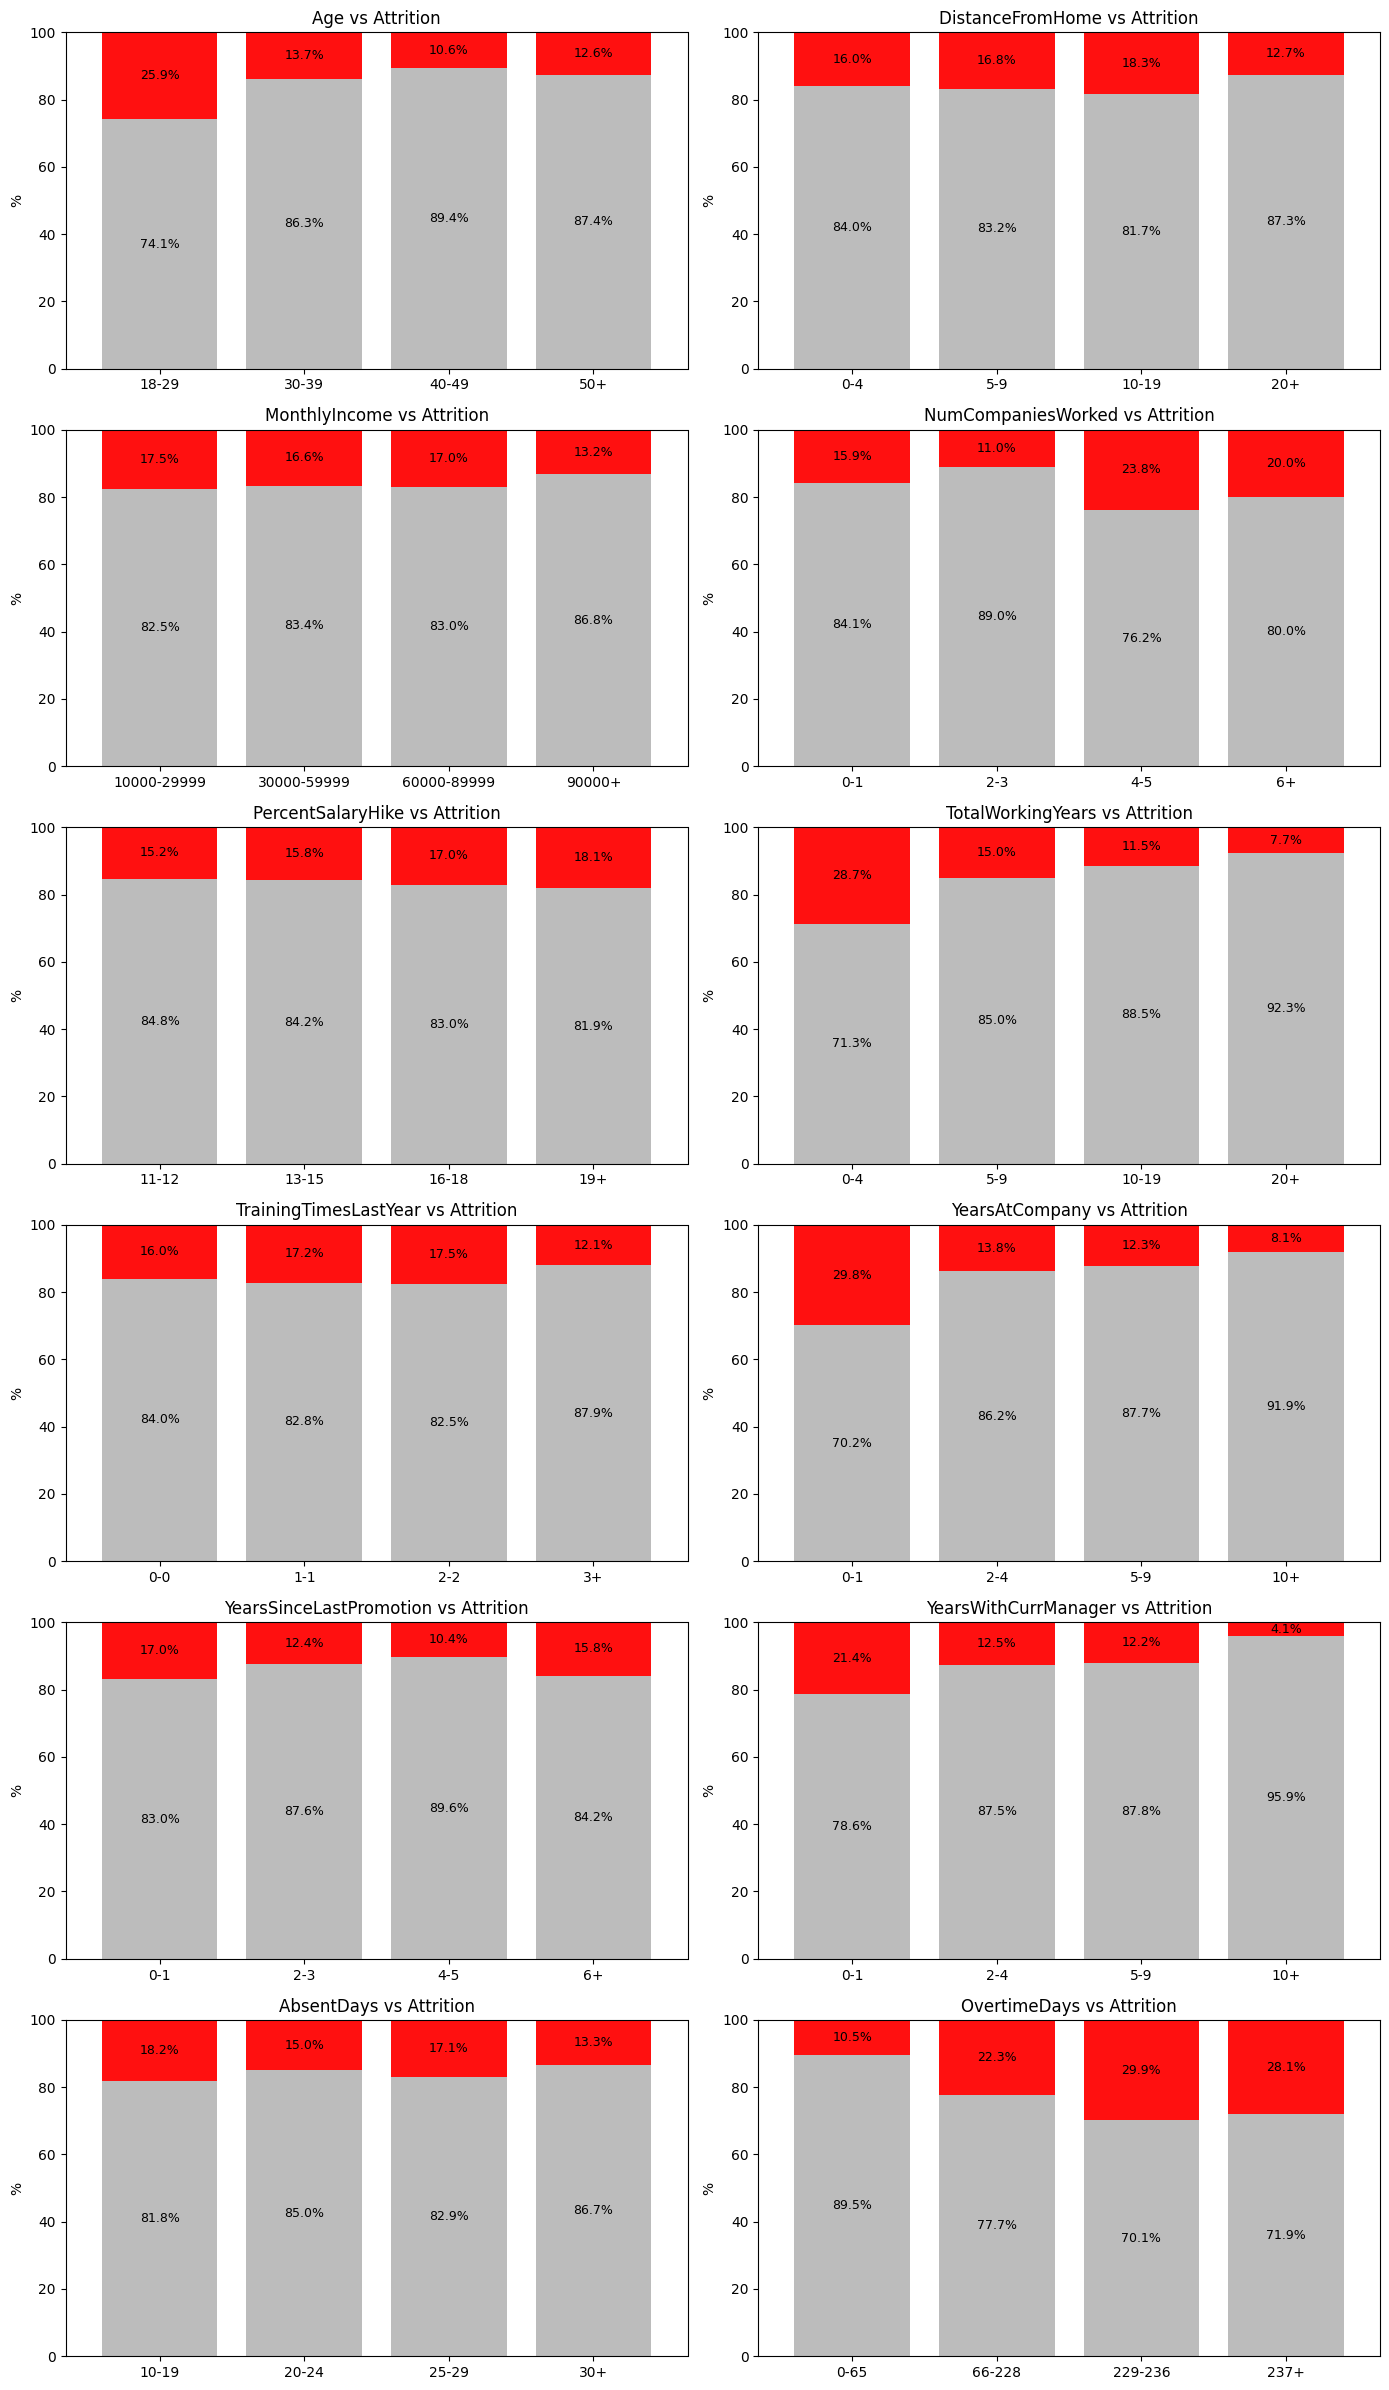

In [24]:
# Stacked Bar Chart for Numerical Features
binning_rules = {
    'Age': [18, 30, 40, 50, 60],
    'DistanceFromHome': [0, 5, 10, 20, 30],
    'MonthlyIncome': [10000, 30000, 60000, 90000, 200000],
    'NumCompaniesWorked': [0, 2, 4, 6, 10],
    'PercentSalaryHike': [11, 13, 16, 19, 26],
    'TotalWorkingYears': [0, 5, 10, 20, 40],
    'TrainingTimesLastYear': [0, 1, 2, 3, 7],
    'YearsAtCompany': [0, 2, 5, 10, 40],
    'YearsSinceLastPromotion': [0, 2, 4, 6, 16],
    'YearsWithCurrManager': [0, 2, 5, 10, 20],
    'AbsentDays': [10, 20, 25, 30, 40],
    'OvertimeDays': [0, 66, 229, 237, 400]
}

plot_stacked_attrition(plot_df, binning_rules)

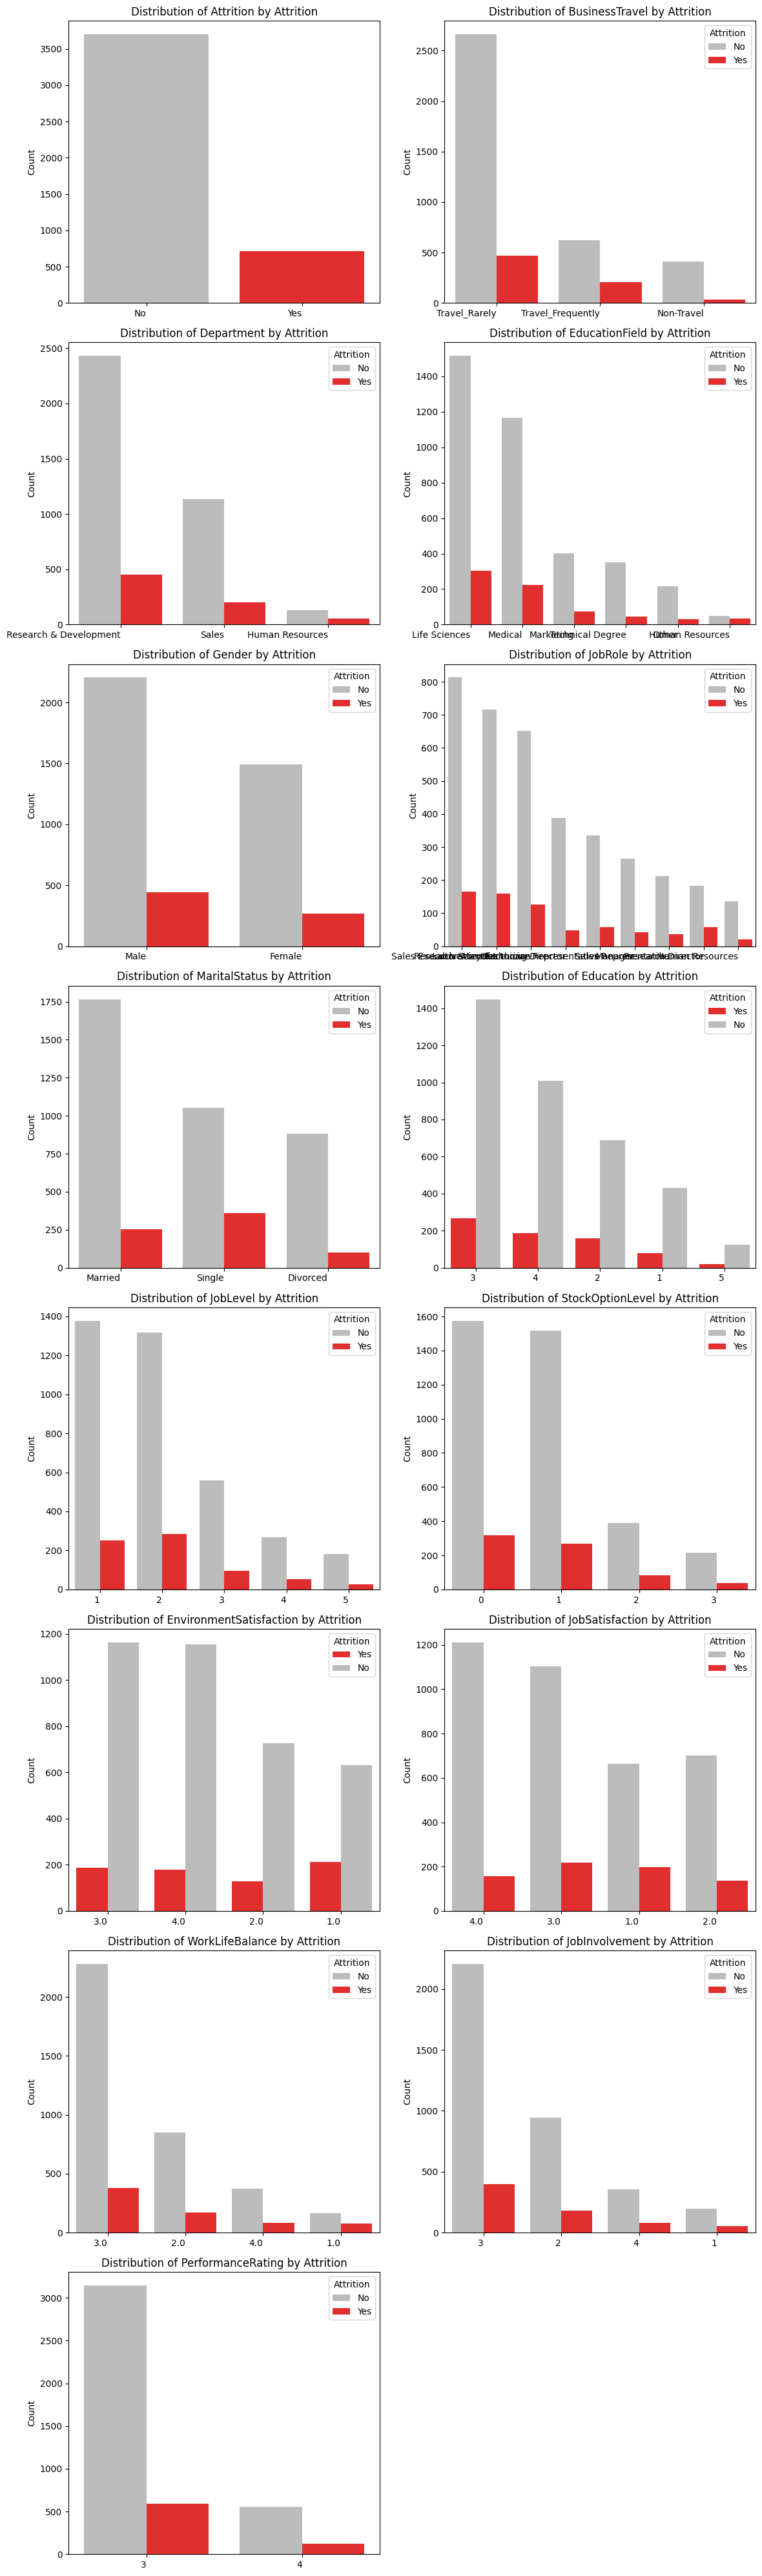

In [25]:
# Bar Charts for Categorical Features
n_cols_plot = 2
n_rows_plot = math.ceil(len(cat_cols) / n_cols_plot)

fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(12, 5 * n_rows_plot)) # Increased height per row
axes = axes.flatten()

for i, col_name in enumerate(cat_cols):
  ax = axes[i]
  order = plot_df[col_name].value_counts().index[:15]

  sns.countplot(
    data=plot_df,
    x=col_name,
    hue='Attrition',
    palette={'Yes': '#FF1010', 'No': '#BCBCBC'},
    ax=ax,
    order=order if plot_df[col_name].nunique() > 15 else plot_df[col_name].value_counts().index
    )
  ax.set_title(f'Distribution of {col_name} by Attrition')
  ax.set_xlabel('')
  ax.set_ylabel('Count')
  for label in ax.get_xticklabels():
    label.set_ha('right')

for j in range(len(cat_cols), len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

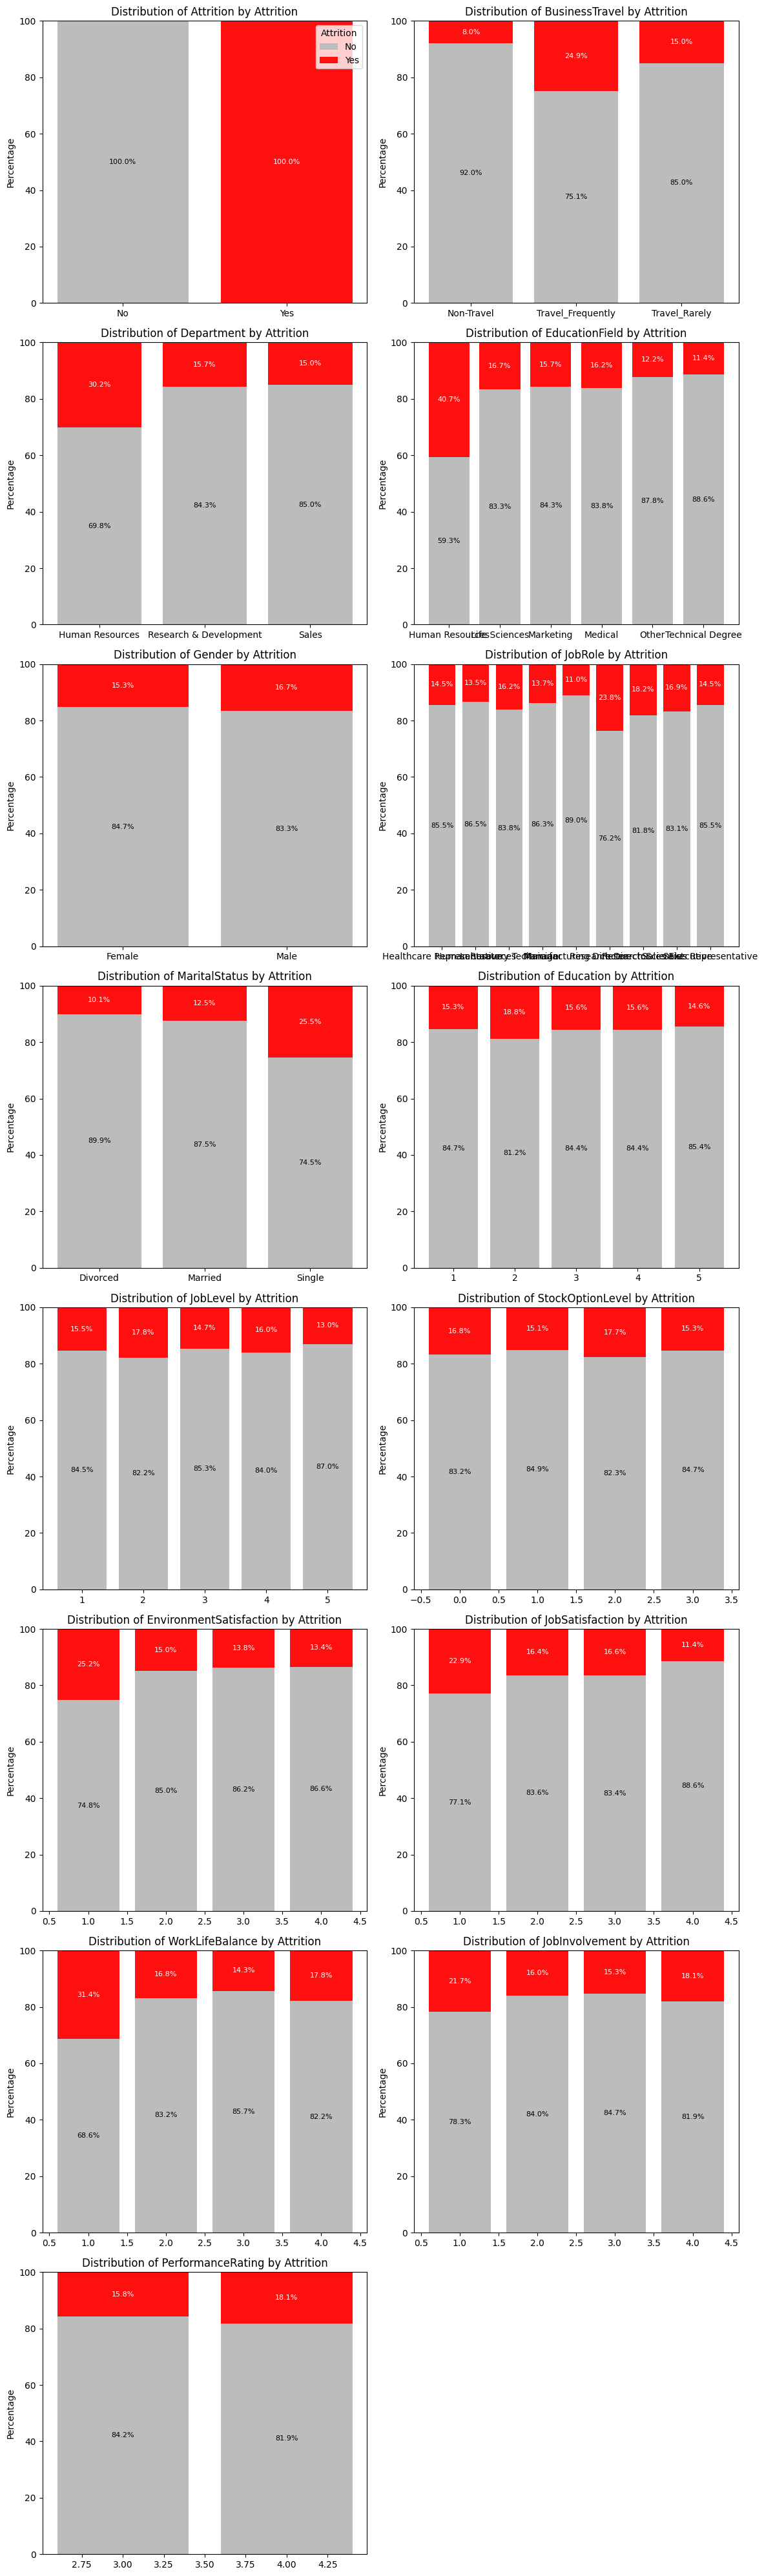

In [26]:
# Stacked Bar Charts for Categorical Features
plot_stacked_bar_categorical(df=plot_df, cat_cols=cat_cols)

### 6.3. When Pay Doesn’t Explain Attrition

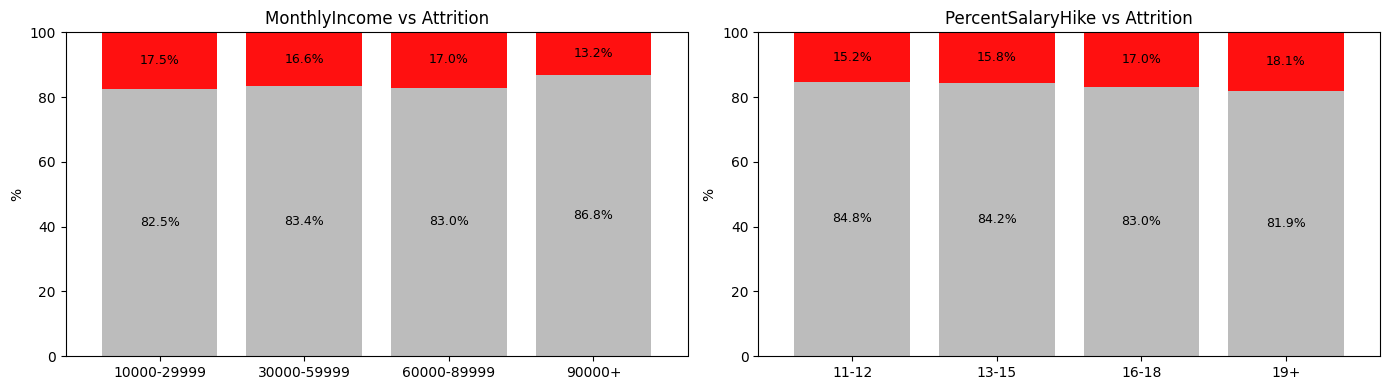

In [27]:
# Define income and salary hike bins for attrition analysis
binning_rules = {
    'MonthlyIncome': [10000, 30000, 60000, 90000, 200000],
    'PercentSalaryHike': [11, 13, 16, 19, 26]
}

# Plot stacked attrition chart with binned data
plot_stacked_attrition(plot_df, binning_rules)

In [28]:
# Analyze relationship between compensation variables and binary target
pay_cols = ['MonthlyIncome', 'PercentSalaryHike']
analyze_numerical_vs_binary(merged_df, pay_cols)

Point-Biserial Correlation for MonthlyIncome: -0.031 (P-value: 0.0384)
Mann–Whitney U Test for MonthlyIncome: U=1264900.50, P-value=0.1072

Point-Biserial Correlation for PercentSalaryHike: 0.033 (P-value: 0.0307)
Mann–Whitney U Test for PercentSalaryHike: U=1379349.00, P-value=0.0373



### 6.4. The Real Culprits: Employee Burnout

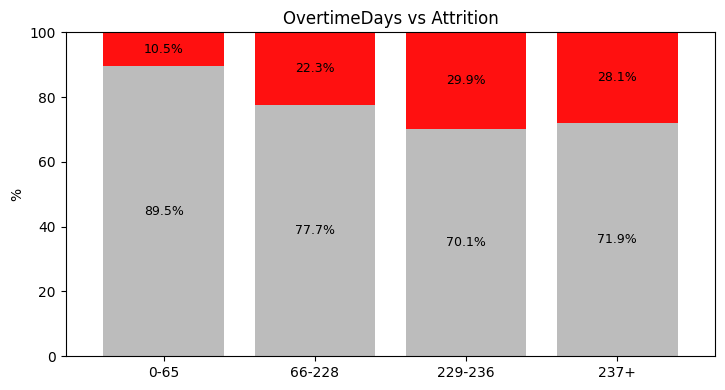

In [29]:
# Define overtime days bins for attrition analysis
binning_rules = {
    'OvertimeDays': [0, 66, 229, 237, 400]
}

# Plot stacked attrition chart with binned data
plot_stacked_attrition(plot_df, binning_rules)

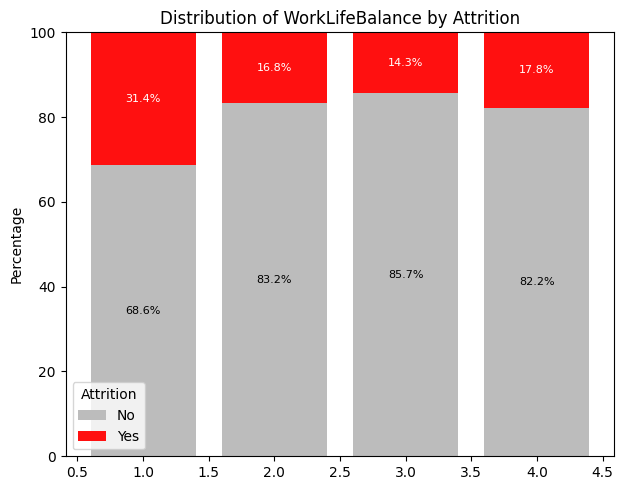

In [30]:
# Plot stacked bar chart showing attrition by work-life balance categories
burn_cols = ['WorkLifeBalance']
plot_stacked_bar_categorical(df=plot_df, cat_cols=burn_cols)

In [31]:
# Analyze relationship between overtime variables and binary target
ot_cols = ['OvertimeDays']
analyze_numerical_vs_binary(merged_df, ot_cols)

burn_cols = ['WorkLifeBalance']
chi_square_test_for_categorical(df=merged_df, cat_cols=burn_cols)

Point-Biserial Correlation for OvertimeDays: 0.234 (P-value: 0.0000)
Mann–Whitney U Test for OvertimeDays: U=1702471.00, P-value=0.0000

Feature: WorkLifeBalance
  - Chi-Square Score   : 5.453
  - P-Value            : 0.0195
  - Degrees of Freedom : 4
  - Critical Value (α=0.05) : 9.488
  - Significance       : Not Significant



### 6.5. The Employee Experience Factor

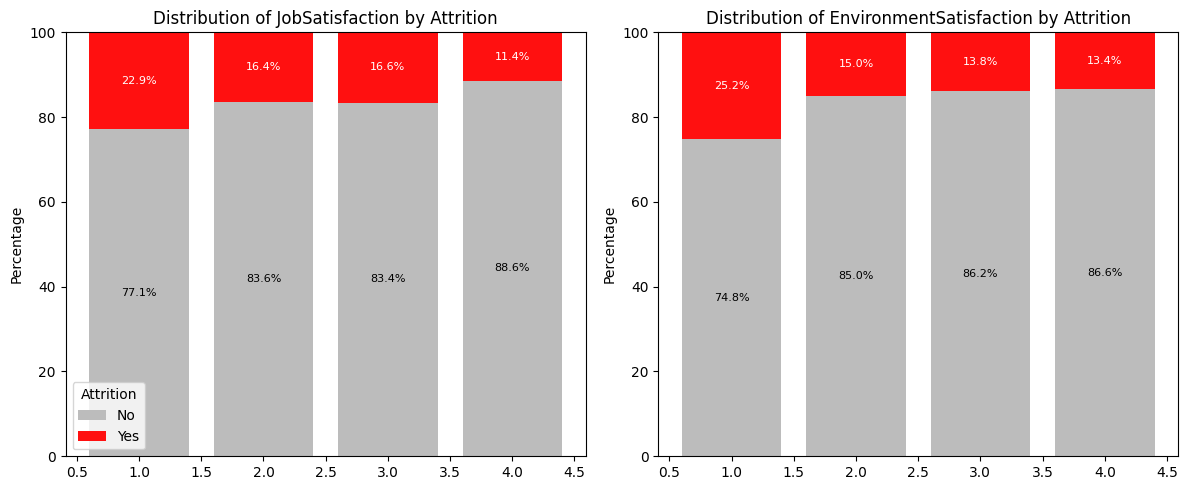

In [32]:
# Plot stacked bar chart showing attrition by satifaction categories
sat_cols = ['JobSatisfaction', 'EnvironmentSatisfaction']
plot_stacked_bar_categorical(df=plot_df, cat_cols=sat_cols)

In [33]:
# Analyze relationship between satisfaction variables and binary target
chi_square_test_for_categorical(df=merged_df, cat_cols=sat_cols)

Feature: JobSatisfaction
  - Chi-Square Score   : 34.128
  - P-Value            : 0.0000
  - Degrees of Freedom : 4
  - Critical Value (α=0.05) : 9.488
  - Significance       : Significant

Feature: EnvironmentSatisfaction
  - Chi-Square Score   : 30.477
  - P-Value            : 0.0000
  - Degrees of Freedom : 4
  - Critical Value (α=0.05) : 9.488
  - Significance       : Significant



### 6.6. Seniority Emerges as a Key Attrition Driver

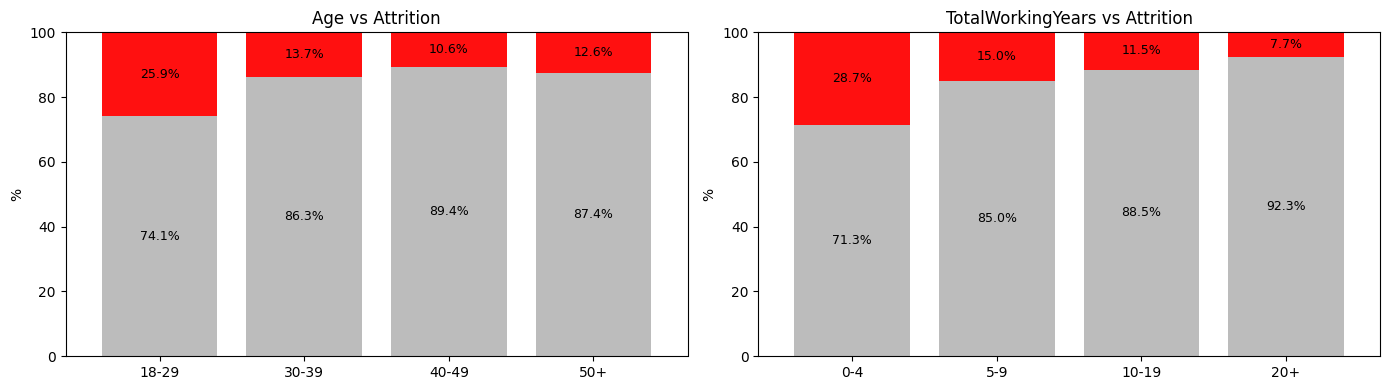

In [34]:
# Define age and total working years hike bins for attrition analysis
binning_rules = {
    'Age': [18, 30, 40, 50, 60],
    'TotalWorkingYears': [0, 5, 10, 20, 40]
}

# Plot stacked attrition chart with binned data
plot_stacked_attrition(plot_df, binning_rules)

In [35]:
# Analyze relationship between age variables and binary target
pay_cols = ['Age', 'TotalWorkingYears']
analyze_numerical_vs_binary(merged_df, pay_cols)

Point-Biserial Correlation for Age: -0.159 (P-value: 0.0000)
Mann–Whitney U Test for Age: U=956854.00, P-value=0.0000

Point-Biserial Correlation for TotalWorkingYears: -0.170 (P-value: 0.0000)
Mann–Whitney U Test for TotalWorkingYears: U=902567.00, P-value=0.0000



### 6.7. Why is HR Leaving?

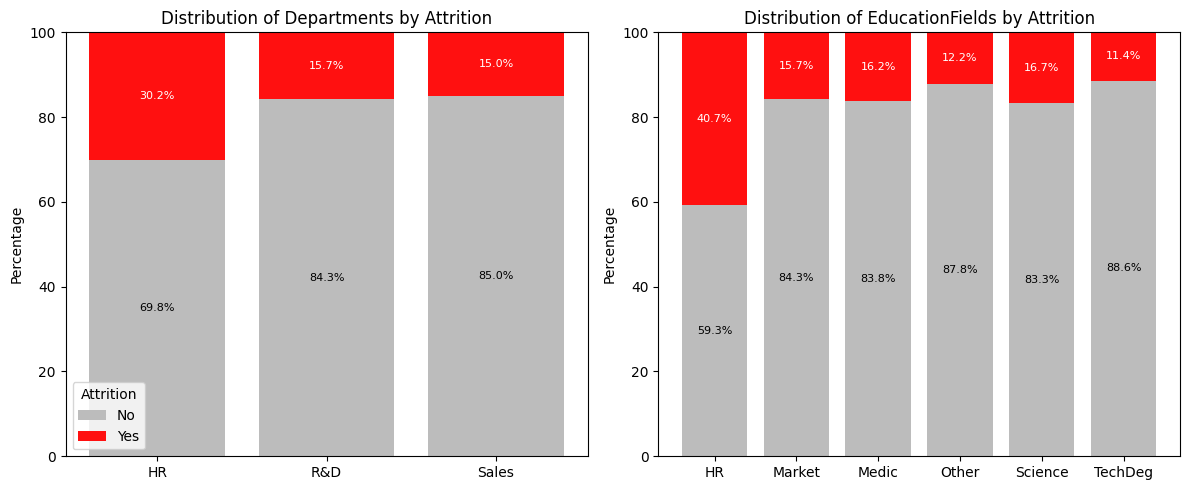

In [36]:
# --- Stacked Bar Chart for Key Categorical Features ---
dept_alias = {
    'Research & Development': 'R&D',
    'Human Resources': 'HR',
    'Sales': 'Sales'
}

edufield_alias = {
    'Human Resources': 'HR',
    'Life Sciences':'Science',
    'Marketing':'Market',
    'Medical':'Medic',
    'Technical Degree':'TechDeg',
    'Other': 'Other'
}

plot_df['Departments'] = plot_df['Department'].map(dept_alias).fillna(plot_df['Department'])
plot_df['EducationFields'] = plot_df['EducationField'].map(edufield_alias).fillna(plot_df['Department'])

sat_cols = ['Departments', 'EducationFields']
plot_stacked_bar_categorical(df=plot_df, cat_cols=sat_cols)

In [79]:
# Check if HR department still affects attrition with controls
plot_df['Dept_HR'] = (plot_df['Department'] == 'Human Resources').astype(int)
plot_df['Attrition_bin'] = (plot_df['Attrition'] == 'Yes').astype(int)
X = plot_df[['Dept_HR', 'TotalWorkingYears', 'Age', 'MonthlyIncome', 'PercentSalaryHike', 'OvertimeDays', 'WorkLifeBalance', 'JobSatisfaction', 'EnvironmentSatisfaction', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']]
X = sm.add_constant(X)
y = plot_df['Attrition_bin']

df_clean = pd.concat([X, y], axis=1).dropna()
X_clean = df_clean.drop(columns='Attrition_bin')
y_clean = df_clean['Attrition_bin']

model = sm.Logit(y_clean, X_clean).fit()
coef_hr = model.params['Dept_HR']
odds_ratio = np.exp(coef_hr)
print(f"\nOdds Ratio Dept_HR: {odds_ratio:.2f}")

Optimization terminated successfully.
         Current function value: 0.367653
         Iterations 7

Odds Ratio Dept_HR: 2.11


Even after controlling for features like age, experience, and salary, HR employees still have significantly higher attrition risk. This indicates that the issue likely stems from the HR department itself, not just from observable factors in the dataset.

### 6.8. Correlation and Relationship Analysis

In [ ]:
# Correlation Matrix
merged_df['Attrition'] = merged_df['Attrition'].map({'Yes': 1, 'No': 0})
nom_cols = ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
associations(
    merged_df,
    nominal_columns=nom_cols,
    mark_columns=True,
    figsize=(24, 18),
    cmap='coolwarm',
    annot=True
)

In [ ]:
# Correlation Matrix for Top 7 Features Most Correlated with Attrition
corr_df = plot_df.copy()
corr_df = corr_df[['OvertimeDays', 'TotalWorkingYears', 'Age', 'YearsWithCurrManager', 'MaritalStatus', 'WorkLifeBalance', 'EnvironmentSatisfaction', 'Attrition']]

nom_cols = ['MaritalStatus', 'Attrition']
associations(
    corr_df,
    nominal_columns=nom_cols,
    mark_columns=True,
    figsize=(12, 8),
    cmap='coolwarm',
    annot=True
)

In [ ]:
# Pair Plot for Numerical Variables, Hued by Attrition
cols_for_pairplot = num_cols + ['Attrition']
final_cols_for_pairplot = [col for col in cols_for_pairplot if col in plot_df.columns]

sns.pairplot(plot_df[final_cols_for_pairplot].dropna(subset=['Attrition']),
 hue='Attrition',
 palette={'Yes': '#FF1010', 'No': '#BCBCBC'},
 diag_kind='kde'
)

plt.suptitle('Pair Plot of Selected Numerical Variables by Attrition', y=1.02)
plt.show()

In [ ]:
# Scatter Plots for Specific Relationships
scatter_plot_pairs = [
    ('TotalWorkingYears', 'MonthlyIncome'),
    ('YearsAtCompany', 'YearsSinceLastPromotion'),
    ('YearsAtCompany', 'YearsWithCurrManager')
]

for x_col, y_col in scatter_plot_pairs:
  plt.figure(figsize=(10, 6))
  sns.scatterplot(x=x_col, y=y_col, hue='Attrition', data=plot_df,
      palette={'Yes': '#FF0000', 'No': '#BCBCBC'}, alpha=0.7)
  plt.title(f'Scatter Plot: {y_col} vs {x_col} by Attrition')
  plt.xlabel(x_col)
  plt.ylabel(y_col)
  plt.show()